In [3]:
from IPython.display import display, Image
Image_Directory = 'C:/Users/Paul/Neural_Networks/Project/Generating_Music/Block_Diagrams/Block_Diagrams'

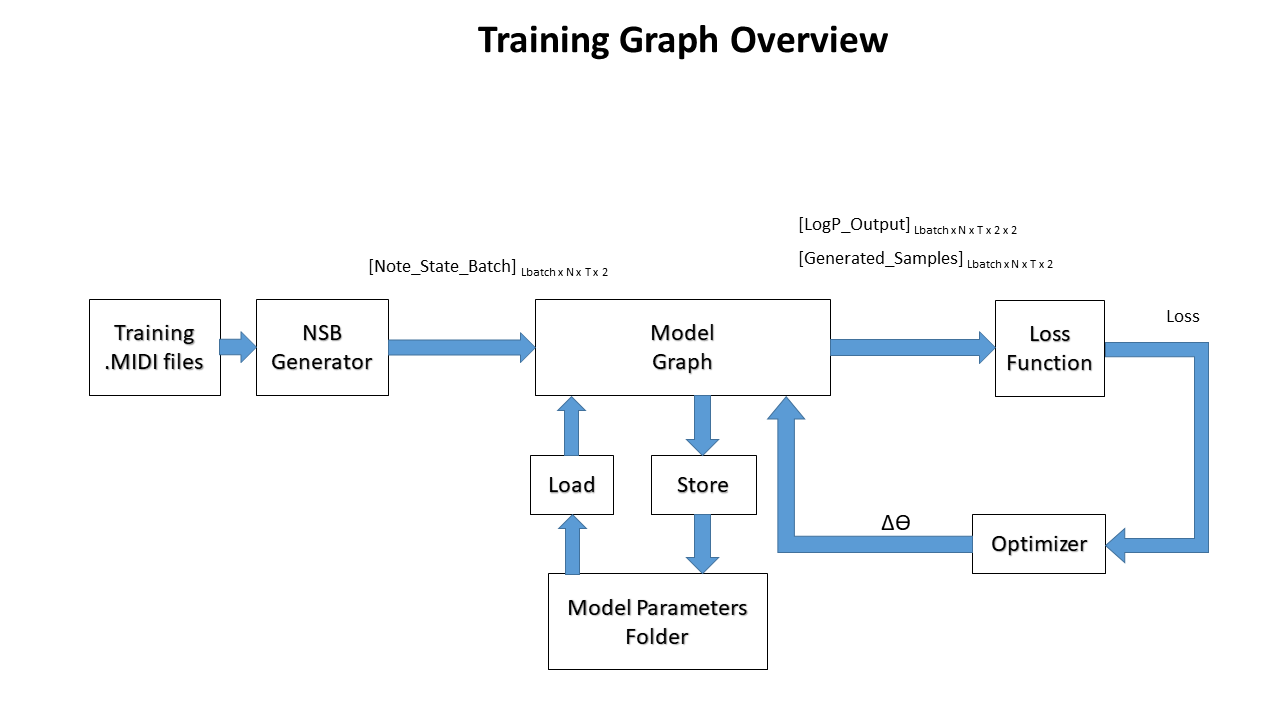

In [7]:
display(Image(filename= Image_Directory + '/' + 'Slide2.png'))

Main Training Loop Overview:
- generate Note_State_Batch from training .MIDI files
- generate corresponding Probability_Output tensor
- Shift logP tensor 1 step in time and calculate Loss graph
- Use optimizer function to update parameters

Quantitative Validation 
- Periodically calculate and store loss from validation .MIDI files
- plot training loss and validation loss versus training iteration

Qualitative Validation
- Periodically (much less frequently) generate batch of music data with current iteration's model parameters and store

## Class - Note State Batch (NSB) Generator 

Arguments:
- location of folder storing the training or validation .MIDI files 
- desired # of .MIDI files
- #Time steps per sample
- #Batches
<br>

Returns:
- Batch of Note State Matrices: a Tensor with dimensions L$_{batch}$ x N x T

Pseudo Code:
<br>
For iter = 1 to $L_{batch}$:
- generate a [Note State Matrix]$_{NxT}$ (feature vector for 1 data point out of the batch) from a random 8 measure segment from a randomly chosen .MIDI file.
- Note_State_Batch(iter,:,:) = Note_State_Matrix  = 

\begin{bmatrix}
 [p , a]_N^{(1)} \cdots [p , a]_N^{(T)}\\
 \vdots\\
  [p , a]_1^{(1)} \cdots [p , a]_1^{(T)}
\end{bmatrix}

where:
$$ 
\begin{align}
- N &= \# \text{ notes in each time step }\\
& \text{ (using MIDI note numbers 24 through 102) } \longrightarrow N = 79 \\
- T &= \# \text{ time steps in feature vector} \\
& \text{ (feature vector is 8 measures at 16 time steps per measure)} \longrightarrow T = 128 \\
- p & \text{ is the 'play' and }  a  \text{ is the 'articulate' binary value} \\
\end{align}
$$

return [Note_State_Batch]$_{L_{batch}xNxT}$










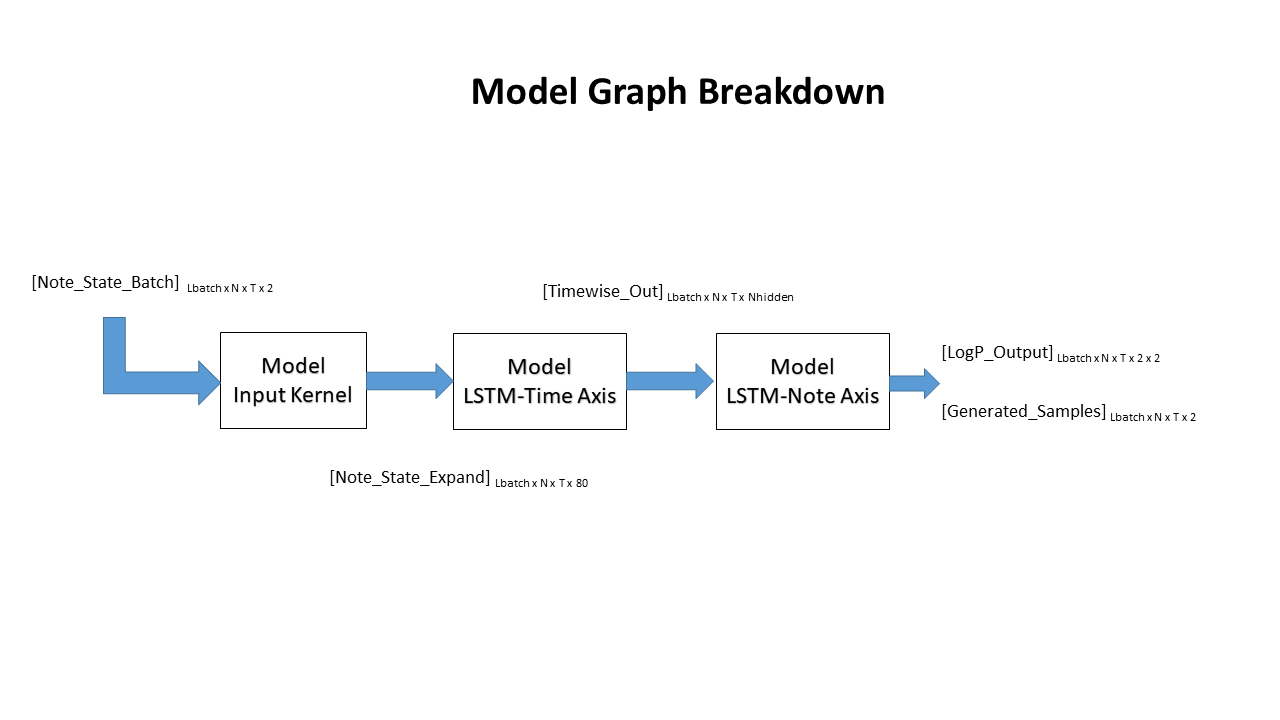

In [6]:
display(Image(filename= Image_Directory + '/' + 'Slide1.png'))


## Class - Model Input Kernel 
Arguments:
- Note_State_Batch: A tensor with dimensions L$_{batch}xTxN$

Returns:
- Note_State_Expand: A tensor with dimensions L$_{batch}xNxTx80$


Description:
- For each note $n$ at each timestep $t$ for every batch, convert $pa_n^{(t)}$ to 80 element vector:
- Similiar a 1D Convolutional layer over the note dimension

Pseudo Code:
<br>
for (iter, n, t) in  ($L_{batch}$, N, T) (operations in parallel)
<br>

$$
\begin{align}
[pa_n^{(t)}] \longrightarrow \text{'Kernel'} \longrightarrow x_n^{(t)} = 
\begin{bmatrix}
[n]_{\text{1x1}} \text{ - MIDI note #}\\  
 \begin{bmatrix}
    0 \\
    \vdots \\
    1 \\
    \vdots \\
    0 \\
\end{bmatrix}_{\text{12x1}} \text{ - 'nth' part_pitchclass}  \\  
 \begin{bmatrix}
    p_{n-12}^{(t)} \\
    a_{n-12}^{(t)} \\
    \vdots \\
    p_{n}^{(t)} \\
    a_{n}^{(t)} \\
    \vdots \\
    p_{n+12}^{(t)} \\
    a_{n+12}^{(t)} \\
\end{bmatrix}_{\text{50x1}} \text{ - part_prev_vicinity} \\
 \begin{bmatrix}
     \text{ pitchclass_count}_{(n)}^{(t)} \\
    \vdots \\
    \# \text{ pitchclass_count}_{(n+11)}^{(t)} \\
\end{bmatrix}_{\text{12x1}} \text{ - part_context}  \\ 
 \begin{bmatrix}
[\text{LSB} \\
\vdots \\
\text{MSB}\\
\end{bmatrix}_{\text{4x1}} \text{ - beat (location in measure)} \\
\begin{bmatrix}
0\\
\end{bmatrix}  - \text{ zero?}
\end{bmatrix}_{\text{80x1}} \\
\end{align}
$$

return [Note_State_Expand]$_{L_{batch}xNxTx80}$

integer or float?

## Model LSTM_TimeAxis
Arguments:
- [Note_State_Filt] $_{L_{batch} x N x T x L_{filt}}$ where L$_{filt}$ = 80

Returns:
- [Hidden_State_Out] $_{L_{batch} x N x T x N_{hidden}}$ where N$_{hidden}$ = # hidden states at that layer


Description: Run NxL$_{batch}$ parallel LSTM networks over T, all with tied weights:

Pseudo Code:
<br>
for (b, n) in (L$_{batch}$, N) (operations in parallel):
<br>
for t = 1:T

- $$
h_n^{(t)} = \text{LSTM}(h_n^{(t-1)}, x_n^{(t)}, \theta_{\text{shared}}) \longrightarrow \text{definition of pseudo code arguments: (previous state, present input, parameters)?}
$$
<br>
- [Hidden_State_Out] (:,n,t,b) = $h_n^{(t)}$

<br>

Return [Hidden_State_Out] $_{L_{batch}xNxTxN_{hidden}}$


## Model LSTM_NoteAxis
Arguments
- [Hidden_State_Final] $_{L_{batch}xNxTxN_{hidden}}$
<br>

Returns
- [Log Probability_Output] $_{L_{batch}xNxTxN_{class}}$
- [Generated Samples] $_{L_{batch}xNxTx1}$
<br>

Description: 
- Run note-wise LSTM networks to generate output note probability for each note at each time step for every batch
- Generates matrix of probabilities of playing and articulating note $n$ at time step $t$ given the musical inputs up to time step $t-1$.  
<br>

Pseuo Code:
<br>
for (b, t) in (L$_{batch}$, T) (operations in parallel):


for n = 1 to N:

$\text{logP}_n^{(t)} = \text{LSTM}(\text{logP}_{n-1}^{(t)},\begin{bmatrix}
h_n^{(t)} \\
{p_{\text{gen}}}_{n-1}^{(t)} \\
{a_{\text{gen}}}_{n-1}^{(t)} \\
\end{bmatrix}, \theta)
 \\
P_n^{(t)} = \text{SoftMax}(\text{logP}_n^{(t)}) = \begin{bmatrix}
P(p_n^{(t)} = 0) \text{ , }
P(p_n^{(t)} = 1) \\
P(a_n^{(t)} = 0)\text{ , }
P(a_n^{(t)} = 1) 
\end{bmatrix} \\
\\
{p_{\text{gen}}}_{n}^{(t)}  = \text{sample} (p_n^{(t)})\\
{a_{\text{gen}}}_{n}^{(t)}  = \text{sample} (a_n^{(t)})
$

Return :
- $[\text{logP}]_{L_{batch} x N x T x 2 x 2}$
- $[pa_{\text{gen}}]_{L_{batch} x N x T x 2}$





# Loss Function
Arguments:
- [Probability_Output] $_{L_{batch} x N x T x 3}$
- [Note_State_Batch] $_{L_{batch} x N x T x 1}$

Returns:
- Loss (scalar)

Description:
- Entries in Probability_Output at time step $t$ were generated by Entries in Note_State_Batch at time step $t$.  i.e. Make sure the probability output of the model at time $t$ lines up with the input for the subsequent input at time step $t+1$, NOT the present time step.  Will to make sure this 1 time step shift is implemented properly when generating the output probability matrix

i.e. [Probability_Output] (:,n,t-1,sample) = $P(va_n^{(t)})$

Pseudo Code:


$$
\text{Loss} = -\frac{1}{TN} \sum_{b=1}^{L_{batch}} \sum_{t=1}^T\sum_{n=1}^N \log (1-v_n^{(t)})P(v_n^{(t)} = 0) + v_n^{(t)}P(v_n^{(t)} = 1) (a_n^{(t)}P(v_n^{(t)} = 1) + (1-a_n^{(t)})P(a_n^{(t)} = 0))
$$


3 Possibilities:
- if note $n$ at time $t$ is NOT played $\longrightarrow$ cost function term = - $P(v_n^{(t)} = 0)$  (don't care about articulation)
- if note $n$ at time $t$ IS played AND articulated $\longrightarrow$ cost function term =  - $P(v_n^{(t)} = 1)P(a_n^{(t)} = 1)$
- if note $n$ at time $t$ IS played and NOT articulated $\longrightarrow$ cost function term =  - $P(v_n^{(t)} = 1)P(a_n^{(t)} = 0)$

# Optimizer

$$
\Delta_{\theta} = f (\nabla_{\theta} \text{ Loss}, \Delta_{\theta - \text{prev}}, \gamma, \cdots) \text{ (based on one of various optimization techniques to be used) }\\
\theta \longleftarrow \theta + \Delta
$$

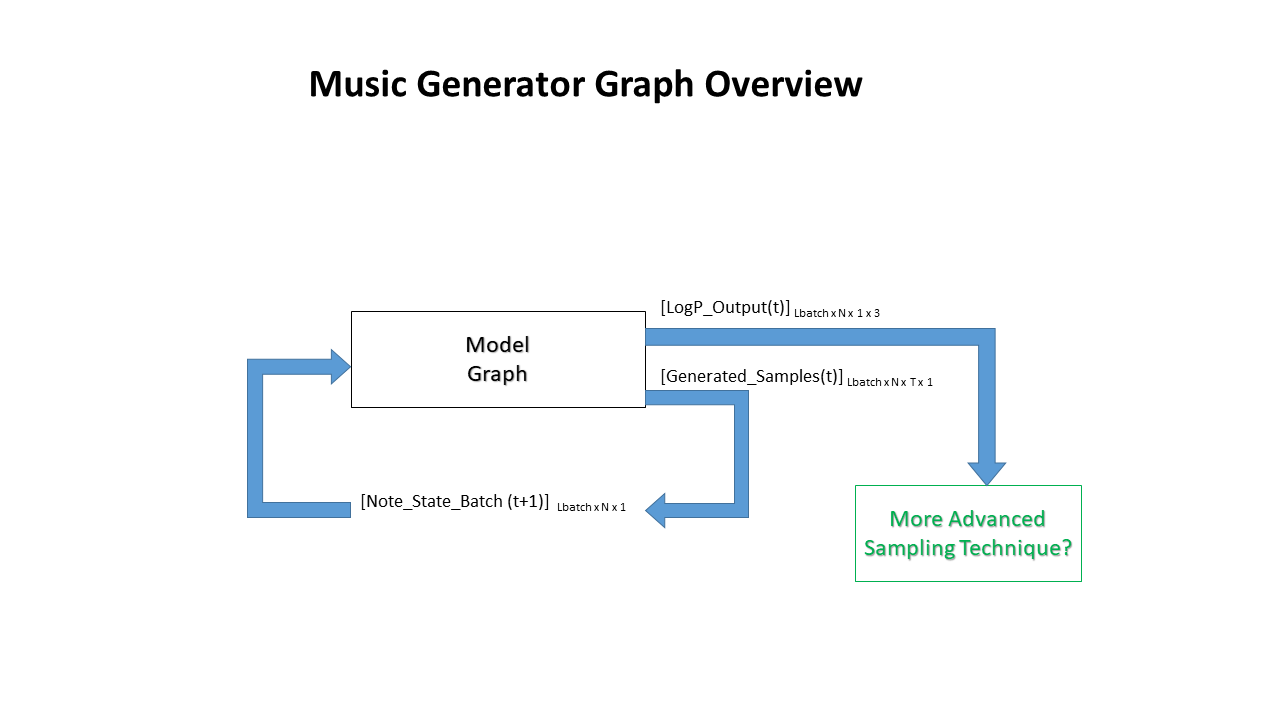

In [7]:
display(Image(filename= Image_Directory + '/' + 'Slide3.png'))

## Music Generator
Arguments

Returns
- [Generated Samples] $_{2xNxTxL_{batch}}$

Description:
- runs through individual time steps of model and feeds back generated sample into next time step.
- this instance of Model Graph will run off a Note_State_Batch where the 'T' dimension = 1.  Furthermore, Note_State_Batch will come from the previously generated samples rather than the NSB generator.  the $L_{batch}$ dimension represents how many pieces of music are being independently run in parallel. 
- During training, the LSTM hidden states from one Note_State_Batch to the next are (I assume) reset from one batch to the next because the musical pieces are not related.  However, for music generation, the batches are different time steps of a single generated piece of music, so the hidden states of the LSTM must be retained.  This is one thing I need to look into as I am not super familiar with the Tensorflow LSTM implementation.


